# **Task 1**
===========================================================================================



In [336]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime
from matplotlib import rc
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



## **Load the datasets**

In [318]:
#Search Trends Dataset
STD = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv')
#Hospitalization Cases Dataset
HCD = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv')
#U.S. Field Production of Crude Oil Dataset
oil = pd.read_csv('https://raw.githubusercontent.com/zhixinyinghua/COMP551/main/DCOILWTICO.csv',error_bad_lines=False)


# Dataset is now stored in a Pandas Dataframe
print(STD.shape) # 624 * 430
print(HCD.shape) # 102912 * 62
print(oil.shape) # 1306 * 2
print(oil_production.shape)

(640, 430)
(102912, 62)
(1306, 2)
(10517, 1)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



## **Clean the data**

In [319]:
#Drop all symptoms with no search data available 
STD_cleaned=STD.dropna(axis=1,how='all')
#Mean Normalization 
#mean across each symptom
mean = pd.DataFrame(STD_cleaned.groupby(["open_covid_region_code"]).mean())
#mean across the symptoms for region
mean_series = mean.mean(axis=1)
#subtract the overall state mean from each symptom, then divide by the overall state mean
STD_cleaned = STD_cleaned.apply(
    lambda x: x.iloc[:8].append
        (x.iloc[8:] / mean_series[x["open_covid_region_code"]]), axis=1)
STD_cleaned.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Ascites,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Compulsive hoarding,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,...,symptom:Osteophyte,symptom:Papule,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Pleurisy,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Postural orthostatic tachycardia syndrome,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,12.69,NaN,NaN,NaN,1.119952,NaN,NaN,NaN,NaN,0.939520,1.011511,0.812854,1.011511,0.722638,1.084413,NaN,1.102638,1.119952,2.584365,1.102638,1.644844,NaN,NaN,0.759089,1.138178,2.349257,0.957746,1.102638,1.463501,NaN,0.722638,0.722638,1.355060,1.409736,...,1.518178,1.029736,0.794628,0.740863,1.011511,NaN,1.047962,NaN,NaN,1.174628,NaN,0.831079,NaN,1.029736,1.029736,NaN,1.662158,1.915492,NaN,1.301295,1.246619,0.740863,NaN,0.831079,0.759089,1.662158,NaN,0.939520,0.903070,0.722638,1.301295,1.445276,1.084413,1.716835,1.264844,NaN,1.283070,0.903070,NaN,1.301295
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,9.56,NaN,NaN,NaN,1.150024,NaN,NaN,NaN,NaN,1.202878,1.202878,0.784604,0.993285,1.080768,0.871175,NaN,0.941343,1.359616,1.847146,1.045228,3.172135,0.906715,NaN,0.749065,NaN,2.282734,1.080768,0.697122,1.847146,1.010600,NaN,NaN,1.621151,1.185564,...,1.254820,1.202878,1.185564,1.045228,1.010600,NaN,0.749065,1.411559,NaN,1.272134,NaN,0.888489,NaN,0.714437,0.731751,0.766379,1.864461,1.533669,1.045228,1.673094,NaN,0.801919,NaN,0.871175,0.993285,1.621151,0.836547,1.411559,1.254820,0.975971,1.220192,1.115396,0.714437,1.533669,1.185564,0.697122,1.394245,0.766379,NaN,1.481727
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,NaN,1.291271,NaN,0.670696,NaN,NaN,1.357794,0.955923,0.754532,1.073477,1.089880,1.609305,NaN,1.022446,1.006043,1.643022,1.056163,1.744173,0.804652,NaN,0.754532,0.955923,2.732902,0.704413,NaN,2.197075,0.922206,1.006043,0.770935,1.626619,1.441631,...,1.291271,1.273957,1.710456,0.754532,0.955923,NaN,0.989640,1.241151,NaN,1.106283,0.770935,0.738130,NaN,0.989640,0.788249,0.720815,1.676739,1.039760,0.838369,1.408825,1.273957,0.770935,NaN,0.872086,1.123597,2.280000,0.770935,1.357794,0.838369,1.123597,1.173717,1.609305,1.391511,1.676739,1.106283,0.687098,0.938609,1.475348,NaN,1.592902
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,15.31,7.47,NaN,NaN,1.427962,0.680720,NaN,0.697122,NaN,1.096259,1.078945,1.195588,NaN,1.096259,0.830168,NaN,0.862974,1.262110,2.175204,1.179185,1.411559,0.896691,NaN,0.946811,1.129065,2.690072,0.896691,0.747242,1.228393,0.780048,0.813765,0.730839,1.245708,1.029736,...,1.909113,1.029736,1.245708,1.328633,1.328633,NaN,0.780048,1.527290,NaN,1.145468,NaN,NaN,NaN,0.913094,1

In [320]:
#keep useful columns
HCD_cleaned=HCD[["region_name","open_covid_region_code","date","hospitalized_new"]]

#Obtain data in US region
HCD_for_USA=pd.DataFrame(columns = ['region_name', 'open_covid_region_code', 'date','hospitalized_new'])
region_code_list=STD['open_covid_region_code'].unique().tolist()
for code in region_code_list:
    HCD_for_USA=HCD_for_USA.append(HCD_cleaned.loc[HCD_cleaned['open_covid_region_code']==code], ignore_index = True)
HCD_cleaned=HCD_for_USA.dropna(how='any')

#filter the region if the sum of hospitalized_new is smaller than 5

HCD_cleaned= HCD_cleaned.groupby(["open_covid_region_code"]).filter(
            lambda x: x["hospitalized_new"].sum() > 0)
HCD_cleaned.head()


,region_name,open_covid_region_code,date,hospitalized_new
682,Hawaii,US-HI,2020-03-04,0.0
683,Hawaii,US-HI,2020-03-05,0.0
684,Hawaii,US-HI,2020-03-06,0.0
685,Hawaii,US-HI,2020-03-07,0.0
686,Hawaii,US-HI,2020-03-08,0.0


In [321]:
oil

,date,Crude Oil Prices
0,10/13/2015,46.7
1,10/14/2015,46.63
2,10/15/2015,46.38
3,10/16/2015,47.3
4,10/19/2015,45.91
...,...,...
1301,10/7/2020,39.82
1302,10/8/2020,41.04
1303,10/9/2020,40.44
1304,10/12/2020,39.22


In [322]:
# #convert date column into datetime object
# oil['date'] = oil['date'].astype('datetime64[ns]')
# oil['column'] = df['column'].replace(np.nan, 0)
# oil_weekly=oil.resample('W-Mon',label='right',closed='right',on='date').sum().reset_index().sort_values(by='date')

# oil_weekly=oil_weekly.loc[(oil_weekly['date']<='2020-9-28')&(oil_weekly['date']>='2020-3-9')]
# #convert daily data to weekly
# # HCD_weekly=HCD_cleaned.groupby("open_covid_region_code").resample('W-Mon',label='right',closed='right',on='date').sum().reset_index().sort_values(by='date')
# # HCD_weekly=HCD_weekly.loc[(HCD_weekly['date']<='2020-9-28')&(HCD_weekly['date']>='2020-3-9')]
# # HCD_weekly
# # oil_weekly=oil.resample('W-Mon',label='right',closed='right',on='date').sum().reset_index().sort_values(by='date')
# oil_weekly

## **Merge the two datasets**

In [323]:
#convert date column into datetime object
HCD_cleaned=HCD_cleaned.copy()
HCD_cleaned['date'] = HCD_cleaned['date'].astype('datetime64[ns]')
STD_cleaned=STD_cleaned.copy()
STD_cleaned['date'] = STD_cleaned['date'].astype('datetime64[ns]')
#convert daily data to weekly
HCD_weekly=HCD_cleaned.groupby("open_covid_region_code").resample('W-Mon',label='right',closed='right',on='date').sum().reset_index().sort_values(by='date')
HCD_weekly=HCD_weekly.loc[(HCD_weekly['date']<='2020-9-28')&(HCD_weekly['date']>='2020-3-9')]
HCD_weekly

,open_covid_region_code,date,hospitalized_new
0,US-HI,2020-03-09,0.0
165,US-NE,2020-03-09,0.0
231,US-NM,2020-03-09,0.0
132,US-ND,2020-03-09,0.0
99,US-MT,2020-03-09,0.0
...,...,...,...
29,US-HI,2020-09-28,86.0
294,US-RI,2020-09-28,32.0
128,US-MT,2020-09-28,122.0
227,US-NH,2020-09-28,11.0


In [324]:
#merge two datasets
STD_cleaned=STD_cleaned.rename(columns={"sub_region_1":"region_name"})
merged_data=pd.merge(STD_cleaned,HCD_weekly,on=['date','open_covid_region_code'])

#remove unnecessary column in the dataframe. 

merged_data=merged_data.drop(['region_name','country_region_code','country_region','sub_region_1_code'],axis=1)
#tune the parameter thresh to 140, 
merged_data=merged_data.dropna(axis=1,thresh=140)

print("merged data:")
print(merged_data.shape)
print(merged_data['open_covid_region_code'].unique())
merged_data.head()

merged data:
(330, 20)
['US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE' 'US-NH' 'US-NM' 'US-RI'
 'US-SD' 'US-WY']


,open_covid_region_code,date,symptom:Allergic conjunctivitis,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Crepitus,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Polydipsia,symptom:Rectal pain,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_new
0,US-HI,2020-03-09,NaN,0.969206,1.921965,NaN,0.944386,NaN,NaN,NaN,2.369038,NaN,NaN,NaN,1.482668,NaN,NaN,NaN,2.990455,0.0
1,US-HI,2020-03-16,NaN,0.857663,1.503003,NaN,1.129495,NaN,NaN,NaN,2.522150,NaN,NaN,NaN,2.505104,NaN,NaN,NaN,2.649543,0.0
2,US-HI,2020-03-23,NaN,0.945582,1.087629,NaN,1.280214,NaN,NaN,NaN,1.732072,NaN,NaN,NaN,2.209049,NaN,NaN,NaN,2.108570,0.0
3,US-HI,2020-03-30,NaN,1.177940,0.850784,NaN,1.079853,NaN,NaN,NaN,1.186314,NaN,NaN,NaN,1.799955,NaN,NaN,NaN,1.398935,12.0
4,US-HI,2020-04-06,NaN,1.084339,0.689898,NaN,0.796657,NaN,NaN,NaN,0.805030,NaN,NaN,NaN,1.330752,NaN,NaN,NaN,0.854373,9.0


# **Task 2**

## **Data visualization**

In [325]:
 
#keep the first 10 most popular symptoms for ploting
sum_column =merged_data.loc[:, 'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].sum(axis=0).sort_values( inplace=False)
sum_column.to_csv('file_name.csv',index=False)
plot_data = merged_data.drop(sum_column.index[:7],axis=1)
plot_data.head()


,open_covid_region_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Crackles,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Rectal pain,symptom:Shallow breathing,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_new
0,US-HI,2020-03-09,0.969206,1.921965,0.944386,NaN,NaN,2.369038,NaN,1.482668,NaN,2.990455,0.0
1,US-HI,2020-03-16,0.857663,1.503003,1.129495,NaN,NaN,2.522150,NaN,2.505104,NaN,2.649543,0.0
2,US-HI,2020-03-23,0.945582,1.087629,1.280214,NaN,NaN,1.732072,NaN,2.209049,NaN,2.108570,0.0
3,US-HI,2020-03-30,1.177940,0.850784,1.079853,NaN,NaN,1.186314,NaN,1.799955,NaN,1.398935,12.0
4,US-HI,2020-04-06,1.084339,0.689898,0.796657,NaN,NaN,0.805030,NaN,1.330752,NaN,0.854373,9.0


Text(0.5, 1.0, 'symptom:Shallow breathing')

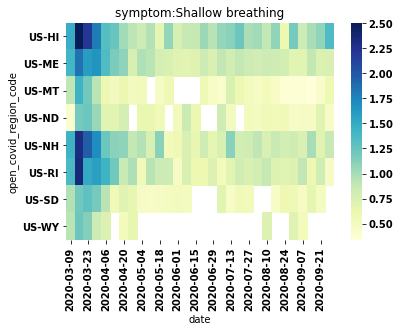

In [326]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
np.random.seed(100)


Cols= pd.to_datetime(plot_data['date']).dt.date
Index = plot_data.open_covid_region_code.unique()

plot=plot_data
heatmap1_data = pd.pivot_table(plot, values='symptom:Shallow breathing', 
                     index=['open_covid_region_code'], 
                     columns=Cols)

sns.heatmap(heatmap1_data, cmap="YlGnBu").set_title('symptom:Shallow breathing')




Text(0.5, 1.0, 'symptom:Rectal pain')

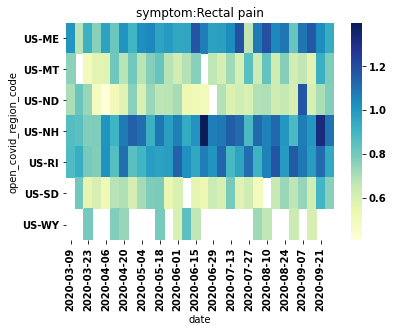

In [327]:
Cols= pd.to_datetime(plot_data['date']).dt.date
Index = plot_data.open_covid_region_code.unique()

plot=plot_data
heatmap1_data = pd.pivot_table(plot, values='symptom:Rectal pain', 
                     index=['open_covid_region_code'], 
                     columns=Cols)

sns.heatmap(heatmap1_data, cmap="YlGnBu").set_title('symptom:Rectal pain')

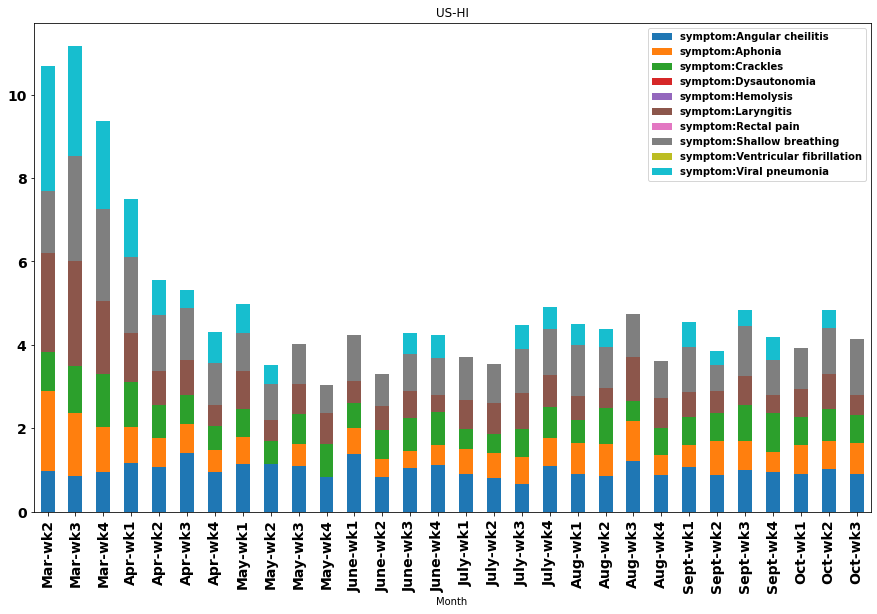

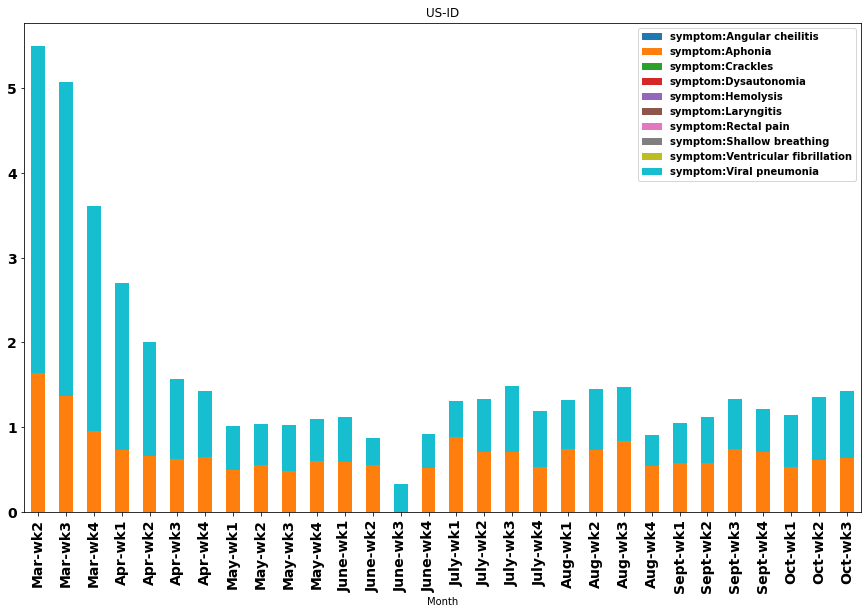

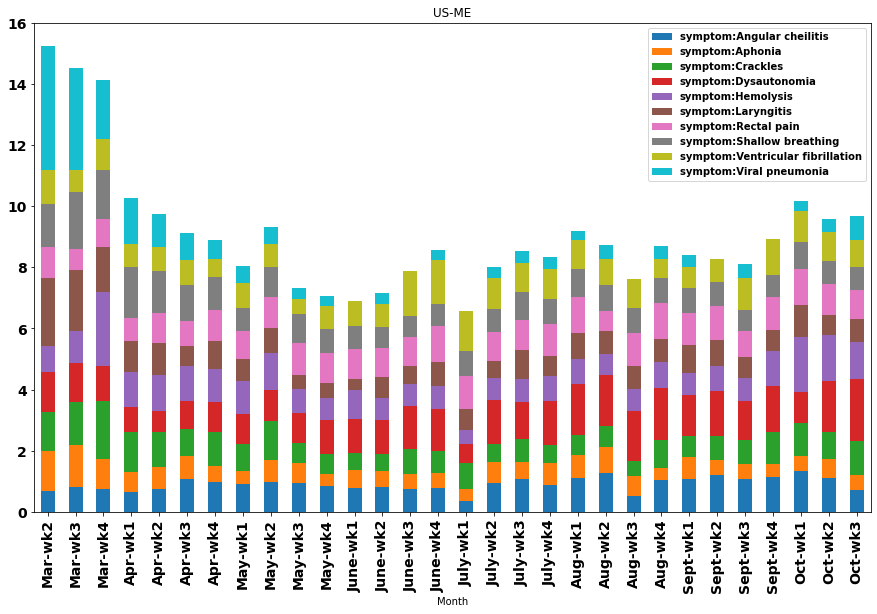

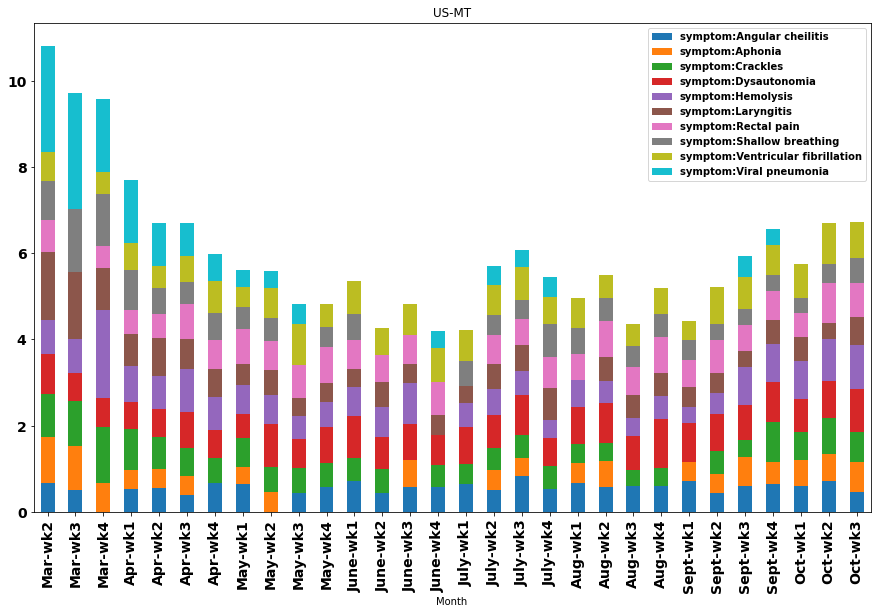

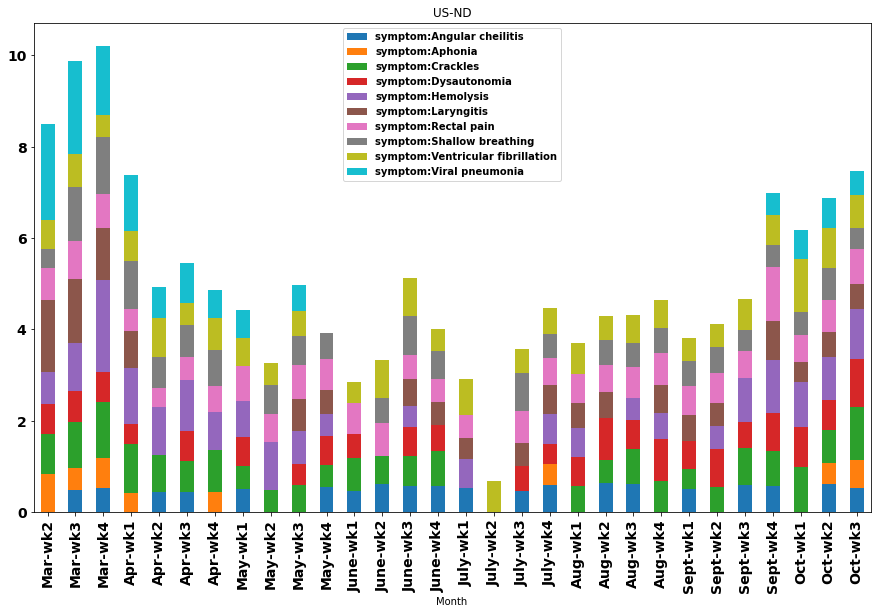

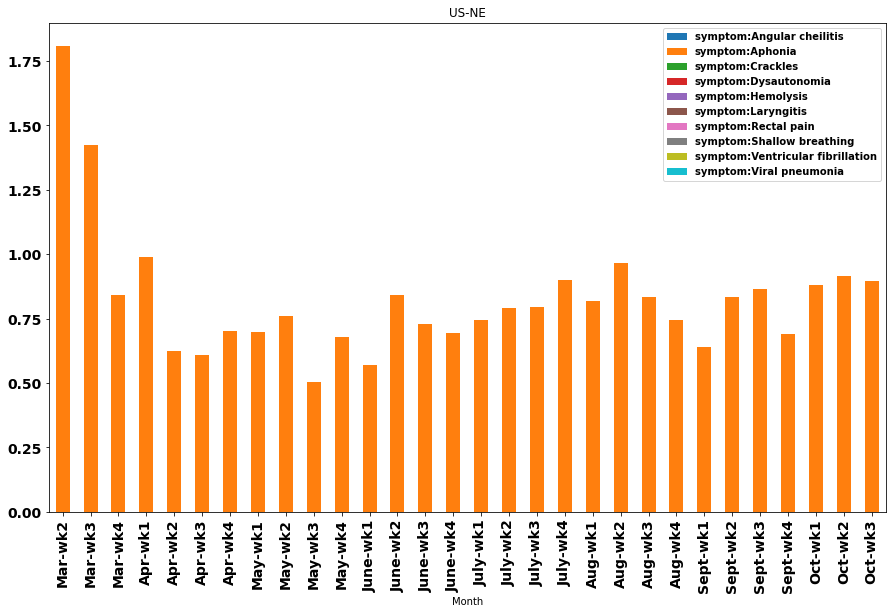

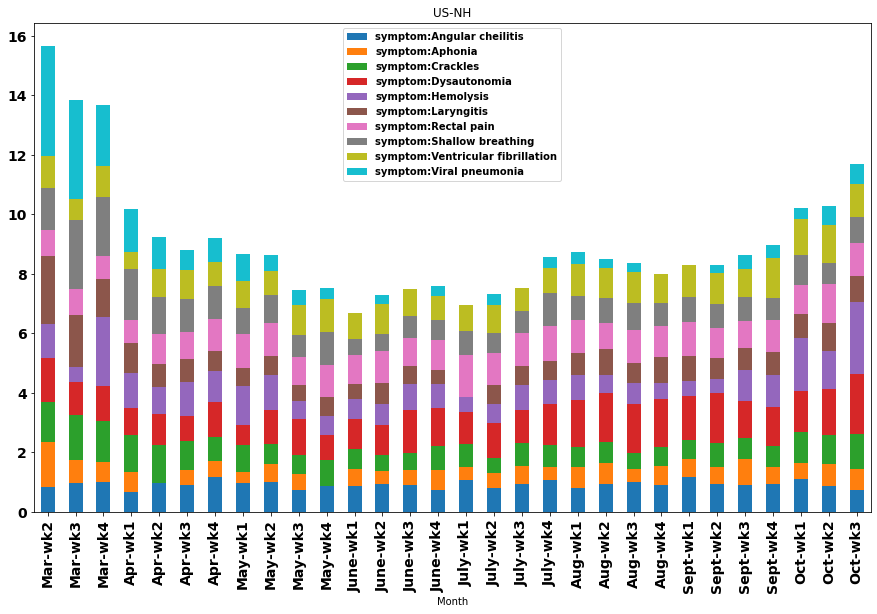

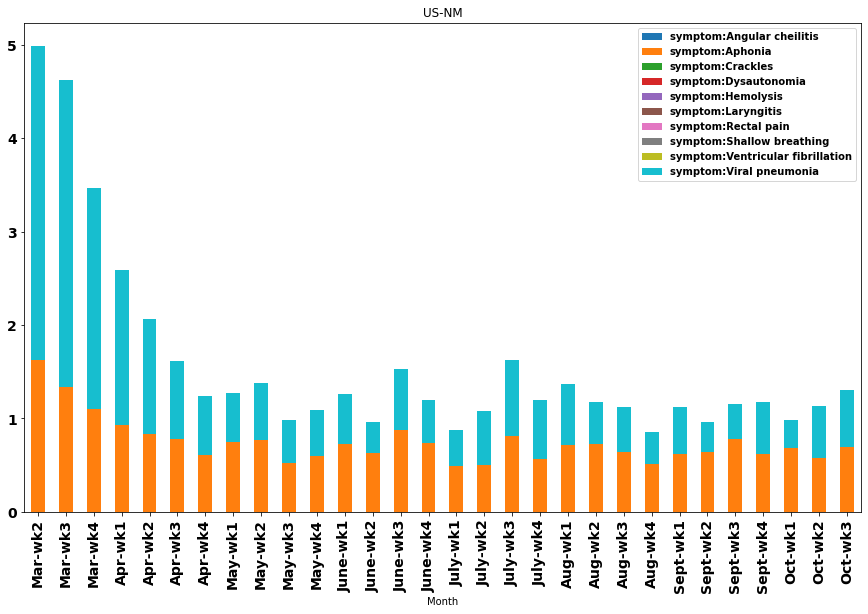

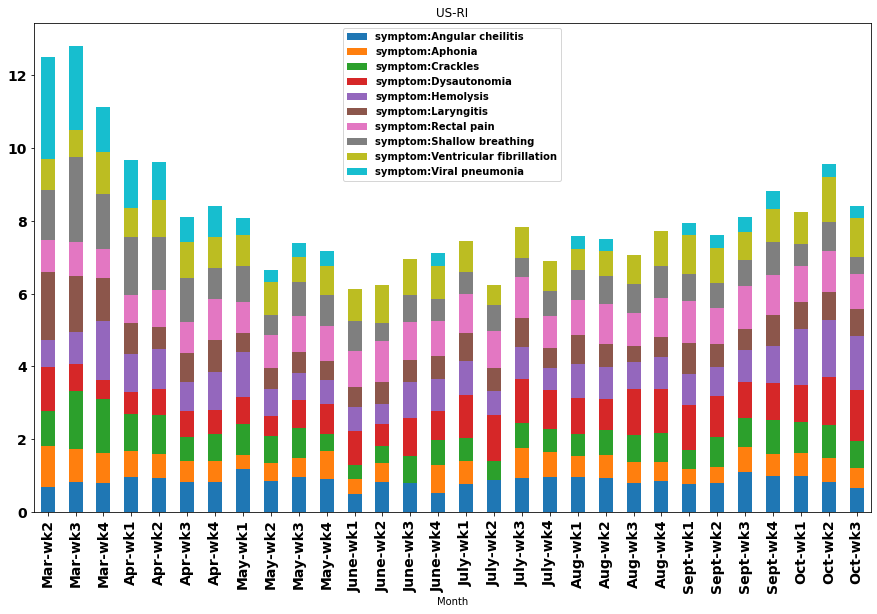

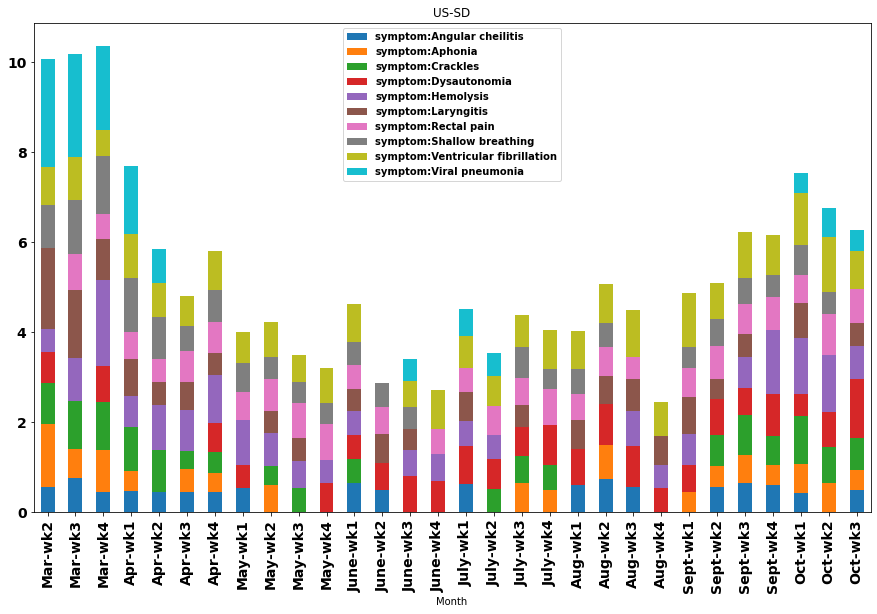

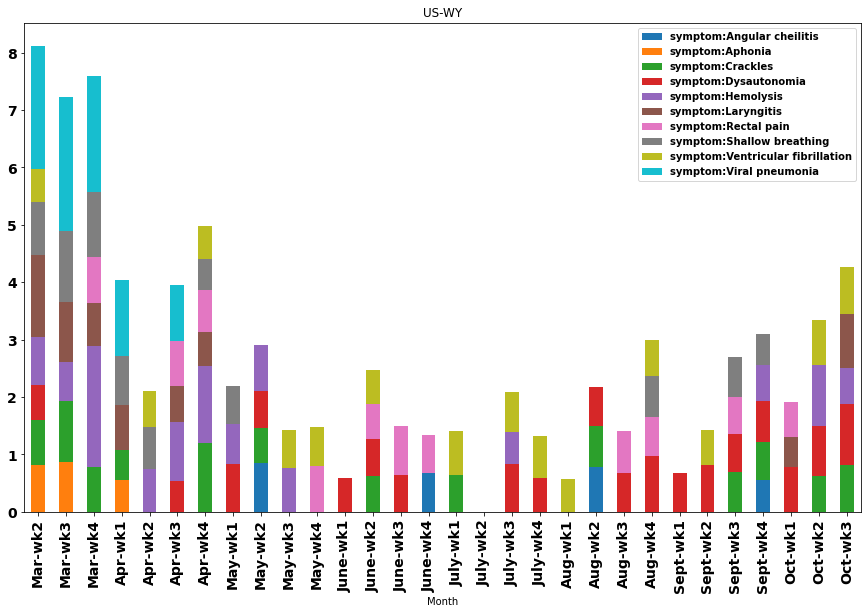

In [328]:

rc('font', weight='bold')
for column in plot_data['open_covid_region_code'].unique().tolist():
   # Select column contents by column name using [] operator
   df = plot_data[plot_data.values==column]

   axis = df.loc[:, 'symptom:Angular cheilitis':'symptom:Viral pneumonia'].plot(
       kind="bar", stacked=True,figsize=(15, 9), fontsize=14)

   months = ["Mar-wk2", "Mar-wk3","Mar-wk4","Apr-wk1","Apr-wk2","Apr-wk3","Apr-wk4", 
         "May-wk1", "May-wk2","May-wk3","May-wk4","June-wk1", "June-wk2","June-wk3","June-wk4",
         "July-wk1","July-wk2","July-wk3","July-wk4","Aug-wk1","Aug-wk2","Aug-wk3","Aug-wk4", 
         "Sept-wk1",  "Sept-wk2", "Sept-wk3", "Sept-wk4","Oct-wk1","Oct-wk2","Oct-wk3"]
  
   axis.set(title = column, xlabel = 'Month')
   
   axis.set_xticklabels(months, fontdict=None, minor=False)
 
   fig = axis.get_figure()

   fig.show
   






## **Choropleth Map**

In [329]:

df = merged_data
df = merged_data[['open_covid_region_code', 'date', 'symptom:Viral pneumonia']]
fig = go.Figure(data=go.Choropleth(
    locations=df['open_covid_region_code'].apply(lambda x: x.replace('US-', '')), # Spatial coordinates
    z = df.sum(axis=1).astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "number of search",
))

fig.update_layout(
    # limite map scope to USA
    title_text = 'COVID19-Viral pneumonia Search trend',
    geo_scope='usa'
)

fig.show()

## **PCA plot**

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



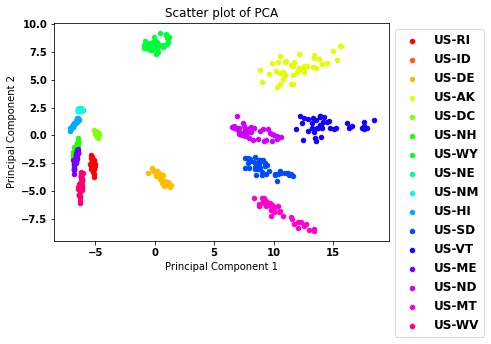

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



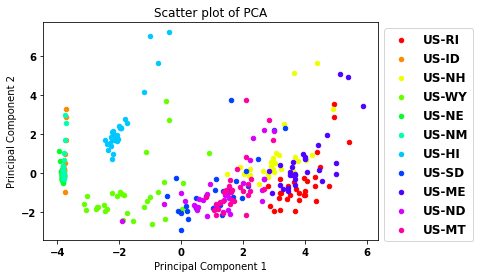

In [330]:
# pca represent a pca type that represent a SEARCH TRENDS DATASET in a lower dimensional space
# treat each time point as in independent data frame
# region is the target

std_raw = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv')
merged_region = pd.DataFrame(merged_data[[i for i in merged_data.columns.tolist() if i.startswith('open_covid_region_code')]])
raw_region = pd.DataFrame(std_raw[[i for i in std_raw.columns.tolist() if i.startswith('open_covid_region_code')]])
class PCADataset:
    # class constructor
    def __init__(self, dataSet= std_raw):
        # load and initialize
        self.x_high_dimensional_dataSet: DataFrame = None
        self.x_low_dimensional_dataSet: DataFrame = None

        self.dataSet = dataSet
        self.load_dataset()
        self.n_component = len(self.x_high_dimensional_dataSet.columns.tolist())
        self.load_dataset()
        self.reduce_dimensionality_2d()


    def load_dataset(self):
        data = self.dataSet
        # reduce the dimension of the symptom
        list_of_symptom = [i for i in data.columns.tolist() if i.startswith('symptom:')]
        self.x_high_dimensional_dataSet = data[list_of_symptom]
        self.x_high_dimensional_dataSet.fillna(0, inplace=True)

    def set_n_component(self, pDimension):
        self.n_component = pDimension

    def reduce_dimensionality_2d(self):
        # set the dimension want to reduce to
        self.set_n_component(2)
        # fit on scaler and apply transform to high dimensional dataset
        sc = StandardScaler()
        hd = self.x_high_dimensional_dataSet
        sc.fit(hd)
        hd = sc.transform(hd)

        # make an instance of PCA, param is the desired dimension
        pca = PCA(n_components=self.n_component)
        self.x_low_dimensional_dataSet = pca.fit_transform(hd)

    def plot_2d_pca(self, cluster= None ):
        if cluster.equals(None):
            cluster = pd.DataFrame(np.array([['Center']* self.dataSet.shape[0]]).T)
        symptom_region = pd.DataFrame(np.concatenate([self.x_low_dimensional_dataSet, cluster], axis=1),
                                      columns=["principal component1", "principal component2",
                                               "cluster"])
        regions = list(set(symptom_region['cluster']))
        hot = plt.get_cmap('hsv')
        cNorm = colors.Normalize(vmin=0, vmax=len(regions))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)
        a = symptom_region['principal component1']
        b = symptom_region['principal component2']
        for region in range(len(regions)):
            indx = symptom_region['cluster'] == regions[region]
            plt.scatter(a[indx], b[indx], s=20, color=scalarMap.to_rgba(region), label=regions[region])
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Scatter plot of PCA')

        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

aPCA = PCADataset(std_raw)
aPCA.plot_2d_pca(raw_region)
plt.show()

aPCA = PCADataset(merged_data)
aPCA.plot_2d_pca(merged_region)
plt.show()




## **K-means**

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



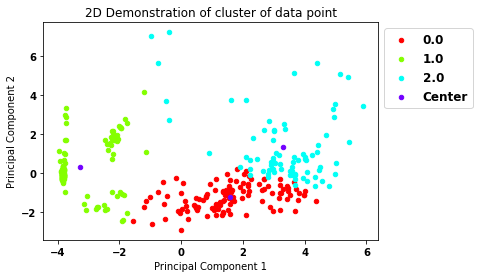

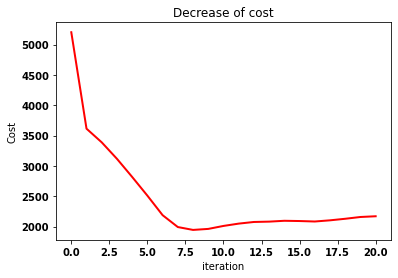

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



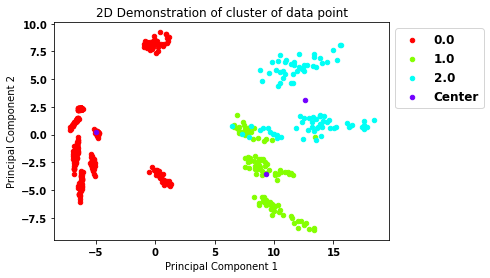

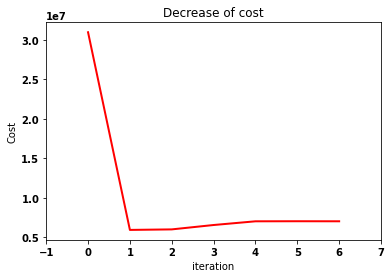

In [331]:
from numpy import mat
from numpy import zeros
from numpy import random
from numpy import inf
from numpy import shape
from numpy import sqrt
from numpy import power
from numpy import nonzero
from numpy import mean
# from pca import PCADataset

STD = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv')


class KMeans:
    def __init__(self,dataset=STD, k=3, max_iters=100):
        self.rawdataset = dataset
        # k is the number of clusters,
        # default 5 clusters
        self.k = k
        # max_iters is the maximum number of iterations for congervence
        # default stop the converging after 100 iterations
        self.max_iters = max_iters
        # load search trend data
        self.data = mat(self.load_search_trend().values)
        # a iteration by 2 matrix for storing the cost in each iteration
        self.cost_over_iteration = None
        self.iteration = 0

    # this method load the search trend data of symptoms
    def load_search_trend(self):
        # get the raw data as a dataframe
        std_raw = self.rawdataset
        # want the search trend of all the symptom
        list_of_symptom = [ i for i in std_raw.columns.tolist() if i.startswith('symptom:')]
        data = std_raw[list_of_symptom]
        # preprocess the data : fill all nan in the dataSet and turn it to a matrix
        data.fillna(0, inplace=True)
        #data = data.values
        #data = mat(data)
        return data

    # this method start the k-means cluster with some random cluster centers
    def initialCenter(self):
        num_of_row, num_of_columns  = self.data.shape
        # build a  num_of_iteration*num_of_columns matrix filled by zeros
        init_centers = mat(zeros((self.k,num_of_columns)))
        # then for every columns, make random numbers within the range
        for i in range(num_of_columns):
            min_value = min(self.data[:, i])
            column_range = float(max(self.data[:, i]) - min_value)
            init_centers[:, i] = mat(min_value + column_range * random.rand(self.k, 1))
        return init_centers

    # There are different method to calculate similarity between data points.
    def euclidean(self, x1, x2):
        return sqrt(np.sum(power(x1 - x2, 2)))
    def manhattan(self, x1, x2):
        return np.sum(np.abs(x1-x2), -1)
    def hamming(self, x1,x2):
        return np.sum((x1!=x2),-1)

    #This method implement the converging in k_means_cluster
    def fit(self):
        # Step 1: start with some random cluster centers (K * num_of_features)
        centers = self.initialCenter()
        # Step 2: creating a matrix (number_of_row in dataset * 2)  to store the result clusters for every row
        #         filling the result matrix by zero
        num_of_row, num_of_column = shape(self.data)
        cluster_for_every_input = mat(zeros((num_of_row, 2)))
        # Step 3: Prepare for iteration untill convergence
        # Record the number of iteration and more iteration is needed
        # Stop the iterations if the number of iterations reach the maximum or no points change its cluster
        more_iteration = True
        # Step 4: creat a matrix to store cost in each iteration, for demonstrating decreasing of cost purpose
        # filling the matrix by inf
        iteration = 0

        self.cost_over_iteration = mat(np.ones((self.max_iters,2))* np.inf)
        # Step 5: implement the convergence
        # Assigning each point to the closet center (define closeness using euclidean distance for search treads of symptoms)
        # Re-caluclate the center of the cluster
        while more_iteration and iteration < self.max_iters:
            more_iteration = False

            # for every data point, find the closest cluster center
            for i in range(num_of_row):
                minDist = inf
                center_index = -1
                for j in range(self.k):
                    data_center_dist = self.euclidean(self.data[i, :], centers[j, :])
                    if data_center_dist < minDist:
                        minDist = data_center_dist
                        center_index = j
                # if the cluster of a data point changed, centers adjust, and more iteration is needed
                if cluster_for_every_input[i,0] != center_index:
                    more_iteration = True
                cluster_for_every_input[i,:] = center_index, data_center_dist ** 2

            # record the cost
            self.cost_over_iteration[iteration,:] = iteration, sum(cluster_for_every_input[:,1])

            # re-calulate the center of every clusters
            for cluster in range(self.k):
                data_in_cluster = self.data[nonzero(cluster_for_every_input[:,0].A == cluster)[0]]
                centers[cluster,:] = mean(data_in_cluster,axis = 0)

            self.iteration = iteration
            iteration = iteration + 1
        return centers, cluster_for_every_input

    # This method do a 2D plot two show the clusters and the centers of each cluster
    # Because there are many symptoms and the clusters are based on all symptoms.
    # But here we can only show two symptoms.: for example the fifth and the eleventh symptom
    def plot_clusters_2d( self, centers, cluster_for_every_input):
        data = pd.DataFrame(self.load_search_trend())
        centers = pd.DataFrame(centers)
        centers.columns = data.columns
        # merge the centers of the clusters to all the data points
        merged_x_centers = pd.concat([data,centers],axis = 0, ignore_index= True)
        # merge the cluster to the index of clusters of all data points
        regions = pd.concat([pd.DataFrame(cluster_for_every_input[:,0]),pd.DataFrame(np.array([['Center']* self.k]).T)])

        p:PCADataset = PCADataset(merged_x_centers)
        p.plot_2d_pca(regions)

        plt.title('2D Demonstration of cluster of data point')
        plt.show()

    # show the cost decease at each iteration
    def plot_cost_decrease(self):
        plt.plot(self.cost_over_iteration[:self.iteration+1,0].tolist(),self.cost_over_iteration[:self.iteration+1,1].tolist(), lw = 2, c="r")
        plt.title('Decrease of cost')
        plt.xlim(-1, self.iteration+1)
        plt.xlabel('iteration')
        plt.ylabel('Cost')
        plt.show()

akmeans = KMeans(dataset=merged_data)
akmeans.load_search_trend()
a, b = akmeans.fit()
akmeans.plot_clusters_2d(a,b)
akmeans.plot_cost_decrease()

akmeans = KMeans(dataset=STD)
akmeans.load_search_trend()
a, b = akmeans.fit()
akmeans.plot_clusters_2d(a,b)
akmeans.plot_cost_decrease()



## **Task 3**

In [332]:
merged_data

,open_covid_region_code,date,symptom:Allergic conjunctivitis,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Crepitus,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Polydipsia,symptom:Rectal pain,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_new
0,US-HI,2020-03-09,NaN,0.969206,1.921965,NaN,0.944386,NaN,NaN,NaN,2.369038,NaN,NaN,NaN,1.482668,NaN,NaN,NaN,2.990455,0.0
1,US-HI,2020-03-16,NaN,0.857663,1.503003,NaN,1.129495,NaN,NaN,NaN,2.522150,NaN,NaN,NaN,2.505104,NaN,NaN,NaN,2.649543,0.0
2,US-HI,2020-03-23,NaN,0.945582,1.087629,NaN,1.280214,NaN,NaN,NaN,1.732072,NaN,NaN,NaN,2.209049,NaN,NaN,NaN,2.108570,0.0
3,US-HI,2020-03-30,NaN,1.177940,0.850784,NaN,1.079853,NaN,NaN,NaN,1.186314,NaN,NaN,NaN,1.799955,NaN,NaN,NaN,1.398935,12.0
4,US-HI,2020-04-06,NaN,1.084339,0.689898,NaN,0.796657,NaN,NaN,NaN,0.805030,NaN,NaN,NaN,1.330752,NaN,NaN,NaN,0.854373,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,US-WY,2020-08-31,NaN,NaN,NaN,NaN,0.696574,0.738124,0.655024,NaN,NaN,NaN,NaN,0.642803,0.708794,NaN,NaN,NaN,NaN,4.0
326,US-WY,2020-09-07,0.537706,0.549926,NaN,0.821224,0.672132,0.606141,0.713682,0.618362,NaN,NaN,NaN,NaN,0.537706,0.606141,NaN,NaN,NaN,4.0
327,US-WY,2020-09-14,NaN,NaN,NaN,NaN,NaN,0.640359,0.774785,NaN,0.535262,NaN,0.547482,0.601253,NaN,0.628138,0.655024,NaN,NaN,11.0
328,US-WY,2020-09-21,NaN,NaN,NaN,0.615918,0.615918,0.655024,0.870106,1.070524,NaN,0.589032,0.535262,NaN,NaN,0.669688,NaN,0.789450,NaN,17.0


In [333]:
#hospitalized_new across the state
total_hospitalized_new = merged_data.groupby(['date'])['hospitalized_new'].sum().reset_index().sort_values('date')
symptom_cols = [ i for i in merged_data.columns.tolist() if i.startswith('symptom:') ]
#symptom across the state
total_symptom = merged_data.groupby(['date'])[symptom_cols].sum().reset_index().sort_values('date')

total_symptom
total_hospitalized_new

,date,hospitalized_new
0,2020-03-09,0.0
1,2020-03-16,0.0
2,2020-03-23,4.0
3,2020-03-30,187.0
4,2020-04-06,193.0
5,2020-04-13,571.0
6,2020-04-20,735.0
7,2020-04-27,422.0
8,2020-05-04,708.0
9,2020-05-11,561.0


-----------decision-tree-------------


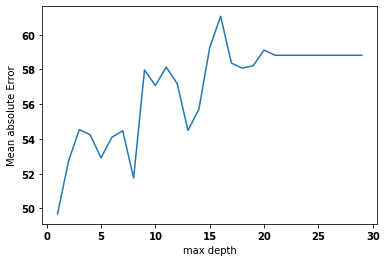

region based split mean absolute error:  mean =  49.68728616370885


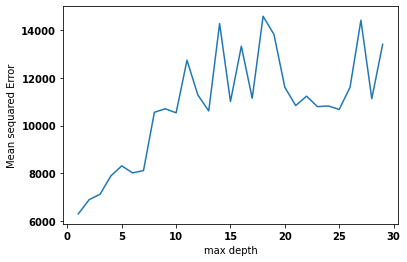

region based split mean square error:  mean =  6311.89833821379
time based split mean absolute error:  -13.112911266201362
time based split mean squared error:  2537.381378288933
-----------KNN-------------


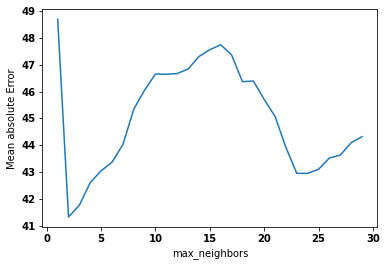

2
region based split mean absolute error:  mean =  41.32111111111111


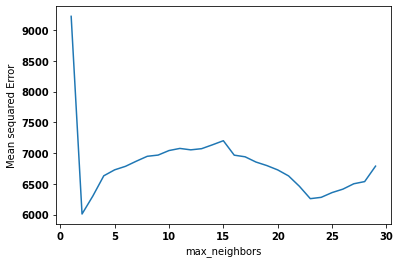

region based split mean square error:  mean =  6010.438888888889
time based split mean absolute error:  -35.81818181818182
time based split mean squared error:  3560.4675324675327
--------multinomial naive bayes------------
region based split mean absolute error:  mean =  45.49111111111111
region based split mean square error:  mean =  6833.48
time based split mean absolute error:  -48.4025974025974
time based split mean squared error:  4712.402597402597


In [334]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from statistics import *

groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range(29):
    groups.extend(b)
groups.sort()
dt = DecisionTreeRegressor(random_state=1)
feature_cols = [ i for i in merged_data.columns.tolist() if i.startswith('symptom:') ]
X = merged_data[feature_cols]
X = X.fillna(0)
X['code'] = groups
Y = merged_data.hospitalized_new
gkf = GroupKFold(n_splits=5)

# split data into train and validation by date

time_ordered_merged_data = merged_data.set_index(merged_data['date'])
time_ordered_merged_data.sort_index()
time_ordered_merged_data = time_ordered_merged_data.fillna(0)
train_time = time_ordered_merged_data[time_ordered_merged_data['date'] <= '2020-08-10']
validation_time = time_ordered_merged_data[time_ordered_merged_data['date'] > '2020-08-10']
X_train = train_time[feature_cols]
Y_train = train_time['hospitalized_new']
X_validation = validation_time[feature_cols]
Y_validation = validation_time['hospitalized_new']

print("-----------decision-tree-------------")
max_depth = np.arange(1, 30)
mae = []
for n in max_depth:
    dt = DecisionTreeRegressor(random_state=1, max_depth=n)
    x = cross_val_score(dt, X, Y, cv=GroupKFold(n_splits=5),
                        groups=groups, scoring="neg_mean_absolute_error")

    mae.append(mean(-1 * x))
plt.plot(max_depth, mae)
plt.xlabel("max depth")
plt.ylabel("Mean absolute Error")
plt.show()
best_depth_mae = max_depth[mae.index(min(mae))]
dt = DecisionTreeRegressor(random_state=1, max_depth=best_depth_mae);
x = cross_val_score(dt, X, Y, cv=GroupKFold(n_splits=5), groups=groups, scoring="neg_mean_absolute_error")

print("region based split mean absolute error: ", "mean = ", mean(-1 * x))
mse = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    x = cross_val_score(dt, X, Y, cv=GroupKFold(n_splits=5),
                        groups=groups, scoring="neg_mean_squared_error")
    mse.append(mean(-1 * x))
plt.plot(max_depth, mse)
plt.xlabel("max depth")
plt.ylabel("Mean sequared Error")
plt.show()
best_depth_mse = max_depth[mse.index(min(mse))]
dt = DecisionTreeRegressor(random_state=1, max_depth=best_depth_mse);
x = cross_val_score(dt, X, Y, cv=GroupKFold(n_splits=5), groups=groups, scoring="neg_mean_squared_error")
print("region based split mean square error: ", "mean = ", mean(-1 * x))

dt.fit(X_train, Y_train)
pred = dt.predict(X_validation)
mae = ((pred - Y_validation)).mean(axis=None)
print("time based split mean absolute error: ", mae)
mse = ((pred - Y_validation) ** 2).mean(axis=None)
print("time based split mean squared error: ", mse)

print("-----------KNN-------------")

max_neighbors = np.arange(1, 30)
mae_neighbors = []
for n in max_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    x = cross_val_score(knn, X, Y, cv=GroupKFold(n_splits=5),
                        groups=groups, scoring="neg_mean_absolute_error")
    mae_neighbors.append(mean(-1 * x))
plt.plot(max_neighbors, mae_neighbors)
plt.xlabel("max_neighbors")
plt.ylabel("Mean absolute Error")
plt.show()
best_neigh_mae = max_neighbors[mae_neighbors.index(min(mae_neighbors))]
print(best_neigh_mae)
knn = KNeighborsClassifier(n_neighbors=best_neigh_mae);
x = cross_val_score(knn, X, Y, cv=GroupKFold(n_splits=5), groups=groups, scoring="neg_mean_absolute_error")

print("region based split mean absolute error: ", "mean = ", mean(-1 * x))

mse_neighbors = []
for n in max_depth:
    knn = KNeighborsClassifier(n_neighbors=n)
    x = cross_val_score(knn, X, Y, cv=GroupKFold(n_splits=5),
                        groups=groups, scoring="neg_mean_squared_error")
    mse_neighbors.append(mean(-1 * x))
plt.plot(max_neighbors, mse_neighbors)
plt.xlabel("max_neighbors")
plt.ylabel("Mean sequared Error")
plt.show()
best_neigh_mse = max_neighbors[mse_neighbors.index(min(mse_neighbors))]
knn = KNeighborsClassifier(n_neighbors=best_neigh_mse);
x = cross_val_score(knn, X, Y, cv=GroupKFold(n_splits=5), groups=groups, scoring="neg_mean_squared_error")
print("region based split mean square error: ", "mean = ", mean(-1 * x))


knn.fit(X_train, Y_train)
pred = knn.predict(X_validation)
mae = ((pred - Y_validation)).mean(axis=None)
print("time based split mean absolute error: ", mae)
mse = ((pred - Y_validation) ** 2).mean(axis=None)
print("time based split mean squared error: ", mse)
print('--------multinomial naive bayes------------')

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()


x=cross_val_score(mnb,X,Y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_absolute_error")

print("region based split mean absolute error: ","mean = ",mean(-1*x))

x=cross_val_score(mnb,X,Y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_squared_error")
print("region based split mean square error: ","mean = ",mean(-1*x))



mnb.fit(X_train,Y_train)
pred=mnb.predict(X_validation)
mae = ((pred - Y_validation)).mean(axis=None)
print("time based split mean absolute error: ",mae)
mse = ((pred - Y_validation)**2).mean(axis=None)
print("time based split mean squared error: ",mse)



In [335]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from statistics import *
import numpy as np
import matplotlib.pyplot as plt


groups=[1,2,3,4,5,6,7,8,9,10,11]
b= [1,2,3,4,5,6,7,8,9,10,11]
for i in range(29):
       groups.extend(b)
groups.sort()
dt= DecisionTreeRegressor(random_state=1)
#feature_cols = ['symptom:Aphonia', 'symptom:Dysautonomia', 'symptom:Shallow breathing', 'symptom:Ventricular fibrillation']
feature_cols = ['symptom:Shallow breathing']
# feature_cols = [
#  'symptom:Angular cheilitis',
#  'symptom:Aphonia',
#  'symptom:Crackles',
#  'symptom:Laryngitis',
#  'symptom:Shallow breathing',
#  'symptom:Ventricular fibrillation',
#  'symptom:Viral pneumonia',
#  ]
# feature_cols = [ i for i in merged_data.columns.tolist() if i.startswith('symptom:')]
merged_data=merged_data[(merged_data.open_covid_region_code!='US-AK')&(merged_data.open_covid_region_code!='US-VT')&(merged_data.open_covid_region_code!='US-WV')&(merged_data.open_covid_region_code!='US-DE')&(merged_data.open_covid_region_code!='US-DC')]
X=merged_data[feature_cols]
X=X.fillna(0)
X['code']=groups
y=merged_data.hospitalized_new
gkf = GroupKFold(n_splits=5)
# for train_index, test_index in gkf.split(X, y, groups=groups):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     print(X_train, X_test, y_train, y_test)

# result=[]
# for train_index, test_index in gkf.split(X, y, groups=groups):
#     train_fold=X.iloc[train_index]
#     val_fold = y.iloc[test_index]
#     result.append((train_fold, val_fold))
# train_fold_1, val_fold_1 = result[0][0],result[0][1]
# train_fold_2, val_fold_2 = result[1][0],result[1][1]
# train_fold_3, val_fold_3 = result[2][0],result[2][1]
# train_fold_4, val_fold_4 = result[3][0],result[3][1]
# train_fold_5, val_fold_5 = result[4][0],result[4][1]
# print(val_fold_2)
# dt.fit(X,y)
# train_fold_1.shape
# val_fold_5.shape

# split data into train and validation by date

time_ordered_merged_data = merged_data.set_index(merged_data['date'])
time_ordered_merged_data.sort_index()
time_ordered_merged_data = time_ordered_merged_data.fillna(0)
train_time = time_ordered_merged_data[time_ordered_merged_data['date'] <= '2020-08-10']
validation_time = time_ordered_merged_data[time_ordered_merged_data['date'] > '2020-08-10']
X_train = train_time[feature_cols]
y_train = train_time['hospitalized_new']
X_validation = validation_time[feature_cols]
y_validation = validation_time['hospitalized_new']

#X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2, random_state=42)
#x=cross_validate(dt,X_train,y_train,cv=gkf,scoring='neg_mean_absolute_error')
#groups=X_train['code']
print("-----------decision-tree-------------")
max_depth = np.arange(1, 30)
mae = []
for n in max_depth:
    dt = DecisionTreeRegressor(random_state=1,max_depth=n)
    x=cross_val_score(dt,X,y,cv=GroupKFold(n_splits=5), 
                            groups=groups,scoring="neg_mean_absolute_error")
    
    mae.append(mean(-1*x))
# plt.plot(max_depth, mae)
# plt.xlabel("max depth")
# plt.ylabel("Mean absolute Error")
# plt.show()
best_depth_mae = max_depth[mae.index(min(mae))]
dt= DecisionTreeRegressor(random_state=1,max_depth=best_depth_mae);
#dt=DecisionTreeRegressor()
x=cross_val_score(dt,X,y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_absolute_error")

#prediction=dt.fit(X_train, y_train).predict(X_test)
#print(prediction)

print("region based split mean absolute error: ","mean = ",mean(-1*x))

mse = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    x=cross_val_score(dt,X,y,cv=GroupKFold(n_splits=5), 
                            groups=groups,scoring="neg_mean_squared_error")
    mse.append(mean(-1*x))
# plt.plot(max_depth, mse)
# plt.xlabel("max depth")
# plt.ylabel("Mean sequared Error")
# plt.show()
best_depth_mse = max_depth[mse.index(min(mse))]
dt= DecisionTreeRegressor(random_state=1,max_depth=best_depth_mse);
x=cross_val_score(dt,X,y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_squared_error")
print("region based split mean square error: ","mean = ",mean(-1*x))

# feature_cols_with_date = ['date','symptom:Aphonia', 'symptom:Dysautonomia', 'symptom:Shallow breathing', 'symptom:Ventricular fibrillation']
# feature_cols = ['symptom:Aphonia', 'symptom:Dysautonomia', 'symptom:Shallow breathing', 'symptom:Ventricular fibrillation']

# time_ordered_merged_data=merged_data.set_index('date')
# X_timesplit=time_ordered_merged_data[feature_cols]
# X_timesplit=X_timesplit.fillna(0)
# y_timesplit=time_ordered_merged_data['hospitalized_new']

# y_train = y_timesplit[:'2020-08-10'].values 
# y_validation = y_timesplit['2020-08-17':].values
# X_train = X_timesplit[:'2020-08-10']
# X_validation = X_timesplit['2020-08-17':]



dt.fit(X_train,y_train)
pred=dt.predict(X_validation)
mae = ((pred - y_validation)).mean(axis=None)
print("time based split mean absolute error: ",mae)
mse = ((pred - y_validation)**2).mean(axis=None)
print("time based split mean squared error: ",mse)

print("-----------KNN-------------")
from sklearn.neighbors import KNeighborsClassifier
max_neighbors = np.arange(1, 30)
mae_neighbors = []
for n in max_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    x=cross_val_score(knn,X,y,cv=GroupKFold(n_splits=5), 
                            groups=groups,scoring="neg_mean_absolute_error")
    mae_neighbors.append(mean(-1*x))
# plt.plot(max_neighbors, mae_neighbors)
# plt.xlabel("max_neighbors")
# plt.ylabel("Mean absolute Error")
# plt.show()
best_neigh_mae = max_neighbors[mae_neighbors.index(min(mae_neighbors))]
print(best_neigh_mae)
knn= KNeighborsClassifier(n_neighbors=best_neigh_mae);
x=cross_val_score(knn,X,y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_absolute_error")

#prediction=dt.fit(X_train, y_train).predict(X_test)
#print(prediction)

print("region based split mean absolute error: ","mean = ",mean(-1*x))

mse_neighbors = []
for n in max_depth:
    knn = KNeighborsClassifier(n_neighbors=n)
    x=cross_val_score(knn,X,y,cv=GroupKFold(n_splits=5), 
                            groups=groups,scoring="neg_mean_squared_error")
    mse_neighbors.append(mean(-1*x))
# plt.plot(max_neighbors, mse_neighbors)
# plt.xlabel("max_neighbors")
# plt.ylabel("Mean sequared Error")
# plt.show()
best_neigh_mse = max_neighbors[mse_neighbors.index(min(mse_neighbors))]
knn= KNeighborsClassifier(n_neighbors=best_neigh_mse);
x=cross_val_score(knn,X,y,cv=GroupKFold(n_splits=5), groups=groups,scoring="neg_mean_squared_error")
print("region based split mean square error: ","mean = ",mean(-1*x))

# feature_cols_with_date = ['date','symptom:Aphonia', 'symptom:Dysautonomia', 'symptom:Shallow breathing', 'symptom:Ventricular fibrillation']
# feature_cols = ['symptom:Aphonia', 'symptom:Dysautonomia', 'symptom:Shallow breathing', 'symptom:Ventricular fibrillation']

# time_ordered_merged_data=merged_data.set_index('date')
# X_timesplit=time_ordered_merged_data[feature_cols]
# X_timesplit=X_timesplit.fillna(0)
# y_timesplit=time_ordered_merged_data['hospitalized_new']
# X_train = X_timesplit[:'2020-08-10']
# X_validation = X_timesplit['2020-08-17':]
# y_train = y_timesplit[:'2020-08-10'].hospitalized_new 
# y_validation = y_timesplit['2020-08-17':].hospitalized_new

# y_train = y_timesplit[:'2020-08-10'].values 
# y_validation = y_timesplit['2020-08-17':].values
# X_train = X_timesplit[:'2020-08-10']
# X_validation = X_timesplit['2020-08-17':]


knn.fit(X_train,y_train)
pred=knn.predict(X_validation)
mae = ((pred - y_validation)).mean(axis=None)
print("time based split mean absolute error: ",mae)
mse = ((pred - y_validation)**2).mean(axis=None)
print("time based split mean squared error: ",mse)
    
# for train, test in gkf.split(X, y, groups=groups):
#     print("%s %s" % (train, test))
    #cv_results = cross_validate(dt, train, test,scoring='neg_mean_absolute_error')
    # b= region_code_list

# for i in range(95):
#        groups.extend(b)



-----------decision-tree-------------
region based split mean absolute error:  mean =  49.032441030153336
region based split mean square error:  mean =  6058.722906878125
time based split mean absolute error:  -14.588140161725077
time based split mean squared error:  1863.1153162776243
-----------KNN-------------
14
region based split mean absolute error:  mean =  42.50555555555555
region based split mean square error:  mean =  6087.35
time based split mean absolute error:  -55.116883116883116
time based split mean squared error:  5046.545454545455
